In [1]:
import torch
import torch.nn as nn
from torch_deeptype import DeeptypeModel

class MyNet(DeeptypeModel):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.input_layer   = nn.Linear(input_dim, hidden_dim)
        self.h1            = nn.Linear(hidden_dim, hidden_dim)
        self.cluster_layer = nn.Linear(hidden_dim, hidden_dim // 2)
        self.output_layer  = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Notice how forward() gets the hidden representations
        hidden = self.get_hidden_representations(x)
        return self.output_layer(hidden)

    def get_input_layer_weights(self) -> torch.Tensor:
        return self.input_layer.weight

    def get_hidden_representations(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.h1(x))
        x = torch.relu(self.cluster_layer(x))
        return x

In [41]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) Configuration
n_samples      = 1000
n_features     = 20
n_informative  = 5     # number of “important” features
n_clusters     = 4     # number of ground-truth clusters
noise_features = n_features - n_informative

# 2) Create distinct cluster centers in the informative subspace
#    (spread out so clusters are well separated)
informative_centers = np.random.randn(n_clusters, n_informative) * 5

# 3) Assign each sample to a cluster, then sample around that center
X_informative = np.zeros((n_samples, n_informative))
y_clusters    = np.random.randint(0, n_clusters, size=n_samples)
for i, c in enumerate(y_clusters):
    center = informative_centers[c]
    X_informative[i] = center + np.random.randn(n_informative)

# 4) Generate pure noise for the remaining features
X_noise = np.random.randn(n_samples, noise_features)

# 5) Concatenate informative + noise features
X = np.hstack([X_informative, X_noise])                # shape (1000, 20)
y = y_clusters                                        # shape (1000,)

# 6) Convert to torch tensors and build DataLoader
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

dataset      = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

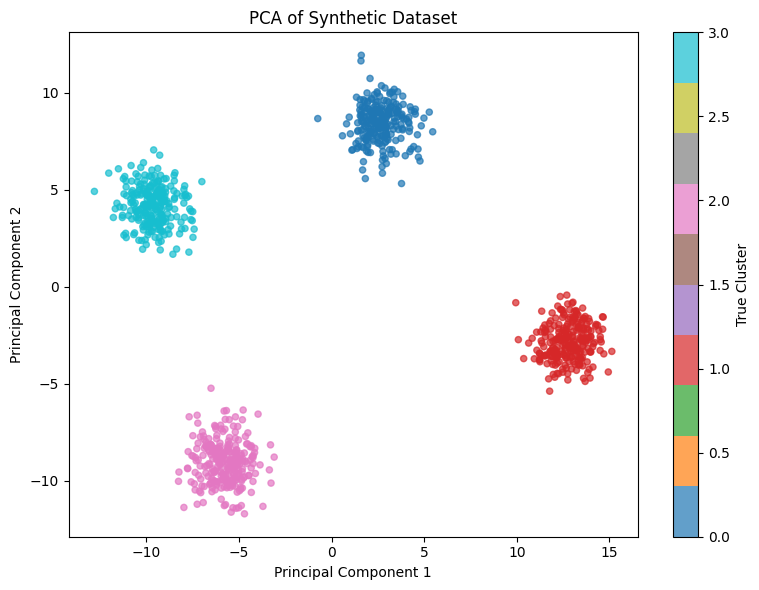

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    components[:, 0],
    components[:, 1],
    c=y,           
    cmap='tab10',
    s=20,
    alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Synthetic Dataset')
plt.colorbar(label='True Cluster')
plt.tight_layout()
plt.show()

In [43]:
from torch_deeptype import DeeptypeTrainer

trainer = DeeptypeTrainer(
    model           = MyNet(input_dim=20, hidden_dim=64, output_dim=5),
    train_loader    = train_loader,
    primary_loss_fn = nn.CrossEntropyLoss(),
    num_clusters    = 4,       # K in KMeans
    sparsity_weight = 0.01,    # α for L₂ sparsity on input weights
    cluster_weight  = 0.5,     # β for cluster‐rep loss
    verbose         = True     # print per-epoch loss summaries
)

In [44]:
trainer.train(
    main_epochs           = 15,     # epochs for joint phase
    main_lr               = 1e-4,   # LR for joint phase
    pretrain_epochs       = 10,     # epochs for pretrain phase
    pretrain_lr           = 1e-3,   # LR for pretrain (defaults to main_lr if None)
    train_steps_per_batch = 8,      # inner updates per batch in joint phase
)

Starting Phase 1: 10 epochs @ lr=0.001
[Epoch 1/10]  Primary: 1.3137  Sparsity: 20.1550
[Epoch 2/10]  Primary: 0.5888  Sparsity: 19.0905
[Epoch 3/10]  Primary: 0.1138  Sparsity: 18.1619
[Epoch 4/10]  Primary: 0.0148  Sparsity: 17.0963
[Epoch 5/10]  Primary: 0.0050  Sparsity: 15.8578
[Epoch 6/10]  Primary: 0.0032  Sparsity: 14.5401
[Epoch 7/10]  Primary: 0.0025  Sparsity: 13.1997
[Epoch 8/10]  Primary: 0.0022  Sparsity: 11.8631
[Epoch 9/10]  Primary: 0.0019  Sparsity: 10.5448
[Epoch 10/10]  Primary: 0.0017  Sparsity: 9.2578
→ Phase 1 training complete.

Starting Phase 2: 15 epochs @ lr=0.0001 with 8 steps/batch
[Phase 2 | Epoch 1/15]  Primary: 0.0022  Sparsity: 8.4073  Cluster: 1.0783
[Phase 2 | Epoch 2/15]  Primary: 0.0040  Sparsity: 8.0508  Cluster: 0.8512
[Phase 2 | Epoch 3/15]  Primary: 0.0059  Sparsity: 7.7068  Cluster: 0.6979
[Phase 2 | Epoch 4/15]  Primary: 0.0099  Sparsity: 7.3606  Cluster: 0.5734
[Phase 2 | Epoch 5/15]  Primary: 0.0120  Sparsity: 7.0239  Cluster: 0.4939
[Phase 

In [45]:
# As expected, first 5 inpts are important
sorted_idx = trainer.model.get_sorted_input_indices()
print("Top 5 features by importance:", sorted_idx[:5].tolist())
print(trainer.model.get_input_importance())

Top 5 features by importance: [3, 1, 4, 2, 0]
tensor([0.7594, 0.8327, 0.8003, 0.9258, 0.8141, 0.0107, 0.0199, 0.0329, 0.0043,
        0.0025, 0.0448, 0.0054, 0.0119, 0.0021, 0.0190, 0.0055, 0.0063, 0.0073,
        0.0059, 0.0189], grad_fn=<LinalgVectorNormBackward0>)


In [46]:
centroids, labels = trainer.get_clusters(dataset)
print(labels)

[1 2 1 2 3 2 2 3 0 1 1 3 3 3 2 0 0 0 1 3 2 1 0 2 1 1 2 3 1 2 0 0 3 0 1 1 3
 3 0 2 2 1 1 3 1 1 0 1 2 1 2 2 1 0 0 3 2 3 3 2 0 1 3 2 1 2 0 2 0 2 1 1 0 0
 0 3 2 0 1 0 1 1 1 3 2 1 3 3 1 2 0 0 2 0 0 2 0 3 2 1 0 1 1 3 3 0 1 1 1 1 2
 1 3 3 3 0 1 2 1 1 3 0 0 3 3 0 1 1 3 3 1 0 2 3 2 2 1 1 0 0 1 0 1 2 0 3 0 0
 0 1 2 2 1 2 0 0 1 3 2 3 3 0 1 0 3 1 2 0 0 1 2 3 0 2 0 2 0 0 2 2 1 2 2 3 2
 1 0 3 1 1 1 2 2 1 3 3 0 1 0 0 1 1 0 2 2 2 2 1 3 2 1 1 0 1 2 1 0 1 1 0 2 3
 3 0 2 2 1 3 2 1 2 2 1 0 3 3 1 0 1 0 0 1 2 2 0 0 3 2 3 0 3 0 0 0 2 0 3 2 1
 2 3 1 3 2 2 3 2 1 3 0 3 0 0 2 3 1 0 3 0 1 3 0 1 3 1 3 2 0 3 0 2 2 1 1 1 2
 1 3 1 2 1 1 2 0 0 1 2 0 1 0 1 2 1 2 0 2 0 2 1 3 2 0 1 0 0 3 0 2 1 1 0 0 3
 3 3 1 3 0 0 0 0 2 2 2 0 0 1 0 1 0 0 1 2 0 3 1 3 0 3 2 1 1 3 0 3 0 0 2 1 0
 1 0 1 3 1 3 1 3 0 3 3 0 1 0 2 0 2 1 1 0 3 3 1 0 3 3 2 1 0 3 3 0 1 3 1 0 0
 3 0 1 3 2 2 1 3 0 1 2 1 1 0 2 3 3 0 0 2 2 3 3 2 0 0 2 2 3 3 0 3 0 2 1 0 0
 3 1 2 0 2 3 3 1 3 1 0 3 3 2 2 2 2 0 3 3 0 3 1 0 3 1 2 2 3 0 0 1 0 1 0 1 1
 1 3 1 3 3 3 2 2 0 3 0 3 

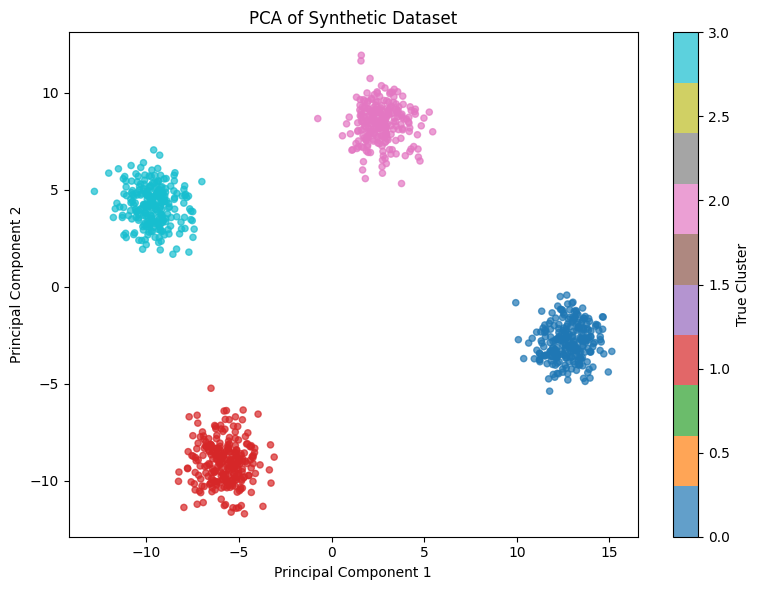

In [47]:
# our clusters were recovered
plt.figure(figsize=(8, 6))
plt.scatter(
    components[:, 0],
    components[:, 1],
    c=labels,           
    cmap='tab10',
    s=20,
    alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Synthetic Dataset')
plt.colorbar(label='True Cluster')
plt.tight_layout()
plt.show()